In [1]:
import pandas as pd
import os

# Folder containing CSVs with sequences of loss values
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'

# List to hold sequences
sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= 10:
                sequences.append(data['Loss'].values)  # assuming the column is named 'loss'
        except:
            print(filename)
            
len(sequences)

507

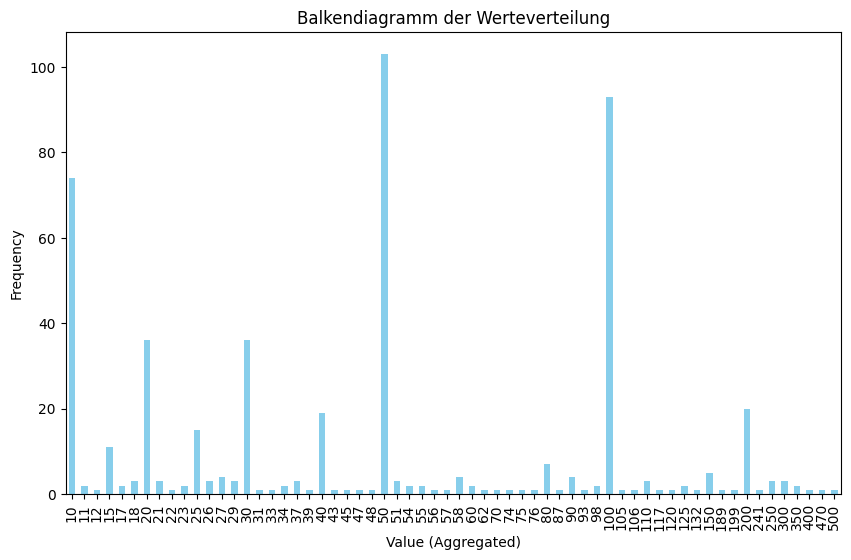

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Generate or load a large dataset
data = [len(df) for df in sequences]  # List of counts per DataFrame in sequences

# Convert data to a DataFrame for easy manipulation
df = pd.DataFrame(data, columns=['count'])

# Optional: Aggregate data to reduce the number of bars (e.g., by frequency counts)
df['count'].value_counts().sort_index().plot(kind='bar', color='skyblue', figsize=(10, 6))

plt.xlabel('Value (Aggregated)')
plt.ylabel('Frequency')
plt.title('Balkendiagramm der Werteverteilung')
plt.show()

In [21]:
import numpy as np

# Define window sizes
input_window = 10   #5  # Input sequence length (n)
output_window = 1  #3  # Output sequence length (m)

# Prepare input-output pairs from sequences
X = []
y = []

for sequence in sequences:
    # Create input-output pairs for each sequence
    for i in range(len(sequence) - input_window - output_window):
        X.append(sequence[i:i+input_window])
        y.append(sequence[i+input_window:i+input_window+output_window])

# Convert to numpy arrays for easier manipulation
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((26526, 10), (26526, 1))

# Visualize Data

outliers: 7


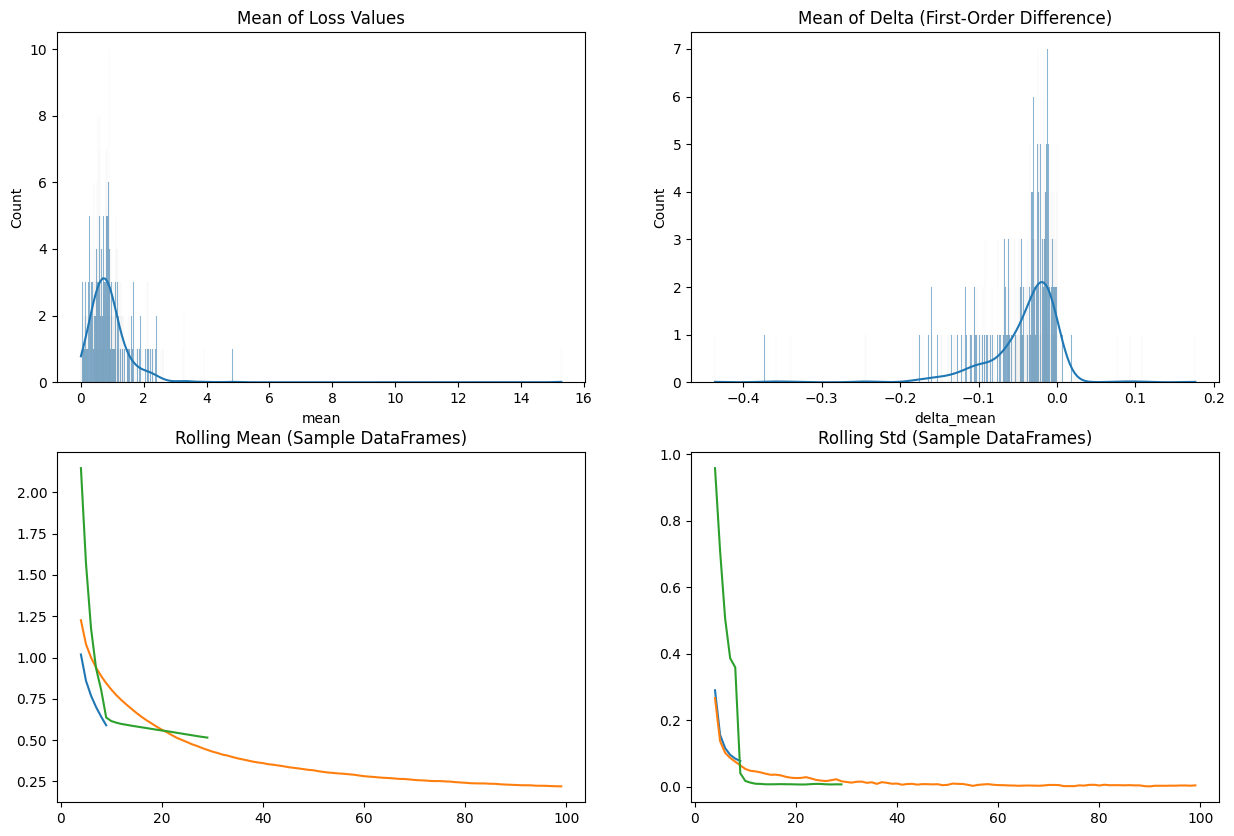

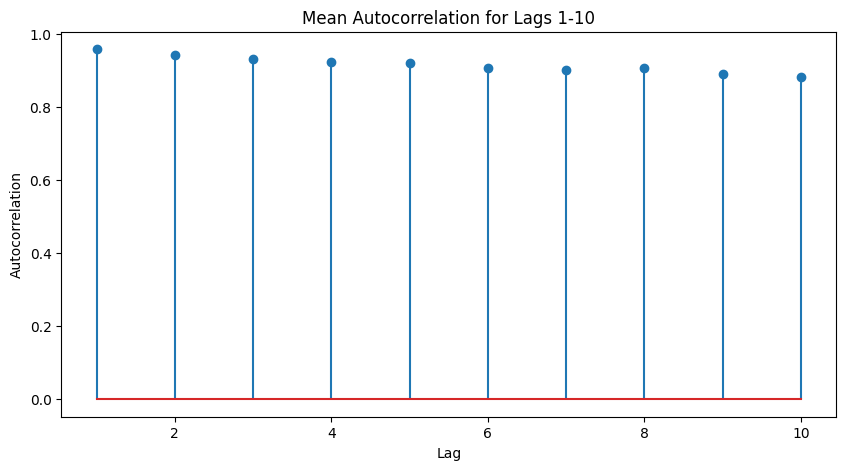

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

def analyze_loss_timeseries(dataframes):
    summary_stats = []
    outliers = 0
    
    for df in dataframes:
        # Convert the loss data to a Pandas Series if it's an ndarray
        loss = pd.Series(df) if isinstance(df, np.ndarray) else df['loss']
        
        # Remove NaN values from the series
        loss = loss.dropna()
        
        # Only proceed if there is enough data in the series
        if len(loss) < 2:
            continue
        
        # First-order difference (delta)
        delta = loss.diff().dropna()
        if any([True for i in list(delta) if abs(i)>10]):
            outliers += 1
            continue
        
        # Rolling statistics
        rolling_mean = loss.rolling(window=5).mean()
        rolling_std = loss.rolling(window=5).std()
        
        # Autocorrelation for lags up to 10
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            autocorr = [loss.autocorr(lag=i) if len(loss) > i else np.nan for i in range(1, 11)]
        
        # Store in a summary dictionary
        stats = {
            'mean': loss.mean(),
            'median': loss.median(),
            'std': loss.std(),
            'delta_mean': delta.mean(),
            'delta_std': delta.std(),
            'autocorr': autocorr
        }
        summary_stats.append(stats)
    print("outliers:", outliers)
    summary_df = pd.DataFrame(summary_stats)
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram of mean and delta mean
    sns.histplot(summary_df['mean'], bins=2000, ax=axes[0, 0], kde=True).set(title='Mean of Loss Values')
    sns.histplot(summary_df['delta_mean'], bins=2000, ax=axes[0, 1], kde=True).set(title='Mean of Delta (First-Order Difference)')
    
    # Manually sample dataframes for rolling mean and std plots
    sample_dataframes = random.sample(dataframes, min(3, len(dataframes)))
    for df in sample_dataframes:
        loss = pd.Series(df) if isinstance(df, np.ndarray) else df['loss']
        rolling_mean = loss.rolling(window=5).mean()
        rolling_std = loss.rolling(window=5).std()
        
        axes[1, 0].plot(rolling_mean, label='Rolling Mean')
        axes[1, 1].plot(rolling_std, label='Rolling Std')
    
    axes[1, 0].set_title('Rolling Mean (Sample DataFrames)')
    axes[1, 1].set_title('Rolling Std (Sample DataFrames)')
    plt.show()
    
    # Autocorrelation plot for lags 1-10
    plt.figure(figsize=(10, 5))
    autocorr_means = np.nanmean([stats['autocorr'] for stats in summary_stats if 'autocorr' in stats], axis=0)
    plt.stem(range(1, 11), autocorr_means)
    plt.title('Mean Autocorrelation for Lags 1-10')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    return summary_df

# Usage
summary_df = analyze_loss_timeseries(sequences)


In [24]:
X[2000], y[2000]

(array([1.3528, 1.3397, 1.3187, 1.2988, 1.2859, 1.266 , 1.2487, 1.2364,
        1.2194, 1.2043]),
 array([1.1912]))

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np

# Model definition (using previous code)
class FloatSequenceTransformer(nn.Module):
    def __init__(self, seq_length=10, embedding_dim=64, num_heads=4, num_layers=4):
        super(FloatSequenceTransformer, self).__init__()
        
        self.embedding = nn.Linear(1, embedding_dim)
        self.register_buffer("positional_encoding", generate_positional_encoding(seq_length, embedding_dim))
        
        transformer_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(embedding_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding
        
        mask = torch.triu(torch.ones(x.size(1), x.size(1)) * float('-inf'), diagonal=1)
        x = self.transformer(x, mask=mask)
        
        x = self.output_layer(x[:, -1, :])
        return x

# Positional encoding function (defined previously)
def generate_positional_encoding(seq_length, embedding_dim):
    position = torch.arange(seq_length).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(np.log(10000.0) / embedding_dim))
    
    pe = torch.zeros(seq_length, embedding_dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

# Adapted Dataset class for X and y arrays
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        input_sequence = self.X[idx]
        target_value = self.y[idx]
        return torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(-1), torch.tensor(target_value, dtype=torch.float32)

# Load your dataset
X = np.random.rand(26526, 10)  # Replace with actual X data
y = np.random.rand(26526, 1)   # Replace with actual y data

# Hyperparameters
seq_length = 10
embedding_dim = 64
num_heads = 4
num_layers = 4
batch_size = 32
learning_rate = 0.001
num_epochs = 50

# Data Preparation
train_dataset = SequenceDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, and Optimizer
model = FloatSequenceTransformer(seq_length=seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

# Prediction on New Data
def predict_next(model, sequence):
    model.eval()
    with torch.no_grad():
        input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        prediction = model(input_sequence)
        return prediction.item()

# Example prediction on a new sequence
new_sequence = np.random.rand(seq_length)  # Generate a new random sequence for testing
predicted_next_value = predict_next(model, new_sequence)
print("Predicted next value:", predicted_next_value)


C:\Users\daV\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [27]:
import torch.optim as optim
import time
from torch.utils.data import DataLoader, TensorDataset
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add an extra dimension for input size
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Create a dataset and a data loader with batching
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 128     #   128 BS  0.15s/batch  ->  1585 batches = 237s   32 BS  0.07s/batch  -> 6338 Batches = 443s
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with batches
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        # Zero gradients
        optimizer.zero_grad()
        
        # Transformer expects (sequence_length, batch_size, d_model) shaped tensors
        X_train = X_batch.permute(1, 0, 2)  # (sequence_length, batch_size, input_size)
        y_train = y_batch.permute(1, 0, 2)
        
        # Predict next loss values
        output = model(X_train, y_train[:-1])  # Use teacher forcing for now
        
        # Compute the loss
        loss = criterion(output, y_train[1:])  # Compare against the actual future loss values
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the batch loss
        epoch_loss += loss.item()

        # Print batch progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(data_loader)}, Batch Loss: {loss.item()}")


Epoch 1/1, Batch 1/208, Batch Loss: nan
Epoch 1/1, Batch 2/208, Batch Loss: nan
Epoch 1/1, Batch 3/208, Batch Loss: nan
Epoch 1/1, Batch 4/208, Batch Loss: nan
Epoch 1/1, Batch 5/208, Batch Loss: nan
Epoch 1/1, Batch 6/208, Batch Loss: nan
Epoch 1/1, Batch 7/208, Batch Loss: nan
Epoch 1/1, Batch 8/208, Batch Loss: nan
Epoch 1/1, Batch 9/208, Batch Loss: nan
Epoch 1/1, Batch 10/208, Batch Loss: nan
Epoch 1/1, Batch 11/208, Batch Loss: nan
Epoch 1/1, Batch 12/208, Batch Loss: nan
Epoch 1/1, Batch 13/208, Batch Loss: nan
Epoch 1/1, Batch 14/208, Batch Loss: nan
Epoch 1/1, Batch 15/208, Batch Loss: nan
Epoch 1/1, Batch 16/208, Batch Loss: nan
Epoch 1/1, Batch 17/208, Batch Loss: nan
Epoch 1/1, Batch 18/208, Batch Loss: nan
Epoch 1/1, Batch 19/208, Batch Loss: nan
Epoch 1/1, Batch 20/208, Batch Loss: nan
Epoch 1/1, Batch 21/208, Batch Loss: nan
Epoch 1/1, Batch 22/208, Batch Loss: nan
Epoch 1/1, Batch 23/208, Batch Loss: nan
Epoch 1/1, Batch 24/208, Batch Loss: nan
Epoch 1/1, Batch 25/208, 

In [31]:
def predict_next_losses(model, input_sequence, output_length=5):
    model.eval()
    
    # Convert input to tensor and reshape
    input_tensor = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # (1, seq_len, 1)
    input_tensor = input_tensor.permute(1, 0, 2)  # (sequence_length, batch_size, input_size)
    
    # Prepare initial target tensor with zeros
    target_tensor = torch.zeros(output_length, 1, 1)  # (output_length, batch_size, input_size)
    
    # Predict next loss values
    with torch.no_grad():
        predicted_loss = model(input_tensor, target_tensor)
    
    return predicted_loss.squeeze(-1).numpy()

# Example prediction
input_sequence = X[1000]  # Use one of the training sequences
predicted_losses = predict_next_losses(model, input_sequence)
print("Predicted next losses:", predicted_losses)
y[1000]


Predicted next losses: [[0.6107825]
 [0.6107825]
 [0.6107825]
 [0.6107825]
 [0.6107825]]


array([0.2432])